In [12]:
## library(igraph)
library(Seurat)
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(ggbeeswarm)
library(patchwork)
library(writexl)
options(ggrepel.max.overlaps = Inf)

In [13]:
cgsf_all = qs::qread('_targets_MAST_v2/objects/combined_gost_seurat_formatted')
cgsf_all %>% head(1)

tag,data_day,cluster,fgf1_day,fgf1_comparison,bl6_day,bl6_comparison,grouping,cells_a,cells_b,⋯,recall,term_id,source,term_name,effective_domain_size,source_order,parents,evidence_codes,intersection,gene_ids
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>,<chr>,<chr>,<chr>
Agrp___Day14.obob14v14__v__Day14.obobBL6d14___bl6_grouping.neg_vs_none,all,Agrp,Day14,obob14v14,Day14,obobBL6d14,bl6_grouping,neg,none,⋯,0.1,GO:0034110,GO:BP,regulation of homotypic cell-cell adhesion,26856,8802,"GO:0022407, GO:0034109","IEA,IMP,ISO,ISO","ENSMUSG00000028530,ENSMUSG00000032020,ENSMUSG00000068220,ENSMUSG00000027947","Jak1,Ubash3b,Lgals1,Il6ra"


In [14]:
combined_deg_seurat_all = qs::qread('_targets_MAST_v2/objects/combined_deg_seurat_formatted')
combined_deg_seurat_all %>% head

tag,data_day,cluster,fgf1_day,fgf1_comparison,bl6_day,bl6_comparison,grouping,cells_a,cells_b,GeneID,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,ensmusg,gsea_sort_score
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Agrp___Day14.obob14v14__v__Day14.obobBL6d14___bl6_grouping.neg_vs_none,all,Agrp,Day14,obob14v14,Day14,obobBL6d14,bl6_grouping,neg,none,Gm42951,1.877929e-10,7.237739,0.804,0.086,1.877929e-06,ENSMUSG00000105254,41.445614
Agrp___Day14.obob14v14__v__Day14.obobBL6d14___bl6_grouping.neg_vs_none,all,Agrp,Day14,obob14v14,Day14,obobBL6d14,bl6_grouping,neg,none,Atp5o,8.617446e-08,6.573415,0.854,0.189,8.617446e-04,ENSMUSG00000022956,20.145027
Agrp___Day14.obob14v14__v__Day14.obobBL6d14___bl6_grouping.neg_vs_none,all,Agrp,Day14,obob14v14,Day14,obobBL6d14,bl6_grouping,neg,none,Ttc9b,8.071365e-08,3.617048,0.856,0.286,8.071365e-04,ENSMUSG00000007944,11.187721
Agrp___Day14.obob14v14__v__Day14.obobBL6d14___bl6_grouping.neg_vs_none,all,Agrp,Day14,obob14v14,Day14,obobBL6d14,bl6_grouping,neg,none,Popdc2,2.160502e-06,6.623428,0.856,0.246,2.160502e-02,ENSMUSG00000022803,11.030956
Agrp___Day14.obob14v14__v__Day14.obobBL6d14___bl6_grouping.neg_vs_none,all,Agrp,Day14,obob14v14,Day14,obobBL6d14,bl6_grouping,neg,none,Cav2,1.291518e-09,2.182259,0.631,0.011,1.291518e-05,ENSMUSG00000000058,10.668847
Agrp___Day14.obob14v14__v__Day14.obobBL6d14___bl6_grouping.neg_vs_none,all,Agrp,Day14,obob14v14,Day14,obobBL6d14,bl6_grouping,neg,none,Inpp4b,4.017654e-10,1.692633,0.986,0.960,4.017654e-06,ENSMUSG00000037940,9.133495


In [15]:
nhgc = qs::qread('_targets_MAST_v2/objects/nhgc_Agrp___Day14.obob14v14__v__Day14.obobBL6d14') # Astrocytes___Day14.obob14v14__v__Day14.obobBL6d14___fgf1_grouping.pos_vs_none
nhgc %>% group_by(fgf1_grouping) %>% summarise(n=n())
nhgc %>% group_by(restored_grouping) %>% summarise(n=n())
# don't worry about this now, just state all markers for all clusters you want

fgf1_grouping,n
<chr>,<int>
none,2123


restored_grouping,n
<fct>,<int>
none,2123


In [16]:
tag2 = combined_deg_seurat_all %>% 
    pull(tag) %>% unique %>%
    str_split(pattern = "___") %>%
    map_chr(~if (length(.x) >= 3) paste(.x[1:2], collapse = "___") else .x[1]) %>%
    unique
        
tag2_tibble = tag2 %>% tibble(tag2=.) %>%
mutate(path_to_target = paste0('_targets_MAST_v2/objects/nhgc_', tag2)) %>%
mutate(obj = purrr::map(path_to_target, ~if (file.exists(.x)) qs::qread(.x) else NA))
    
combined_tibble <- tag2_tibble %>%
  mutate(obj = map2(obj, tag2, ~if (!is.na(.x)) mutate(.x, tag2 = .y) else tibble())) %>%
  pull(obj) %>%
  map_dfr(identity)

Warning message:
“There were 61 warnings in `mutate()`.
The first warning was:
ℹ In argument: `obj = map2(obj, tag2, ~if (!is.na(.x)) mutate(.x, tag2 = .y)
  else tibble())`.
Caused by warning in `if (!is.na(.x)) ...`:
! the condition has length > 1 and only the first element will be used
ℹ Run `dplyr::last_dplyr_warnings()` to see the 60 remaining warnings.”


In [17]:
library(dplyr)
library(tidyr)

# Tibble for fgf1_grouping
fgf1_tibble <- combined_tibble %>% 
  filter(fgf1_grouping %in% c('neg', 'none', 'pos')) %>%
  group_by(tag2, fgf1_grouping) %>%
  summarise(count = n(), .groups = "drop") %>%
  pivot_wider(names_from = fgf1_grouping, values_from = count, names_prefix = "fgf1_", values_fill = 0) %>%
  rowwise() %>%
  mutate(total_cells = sum(c_across(-tag2), na.rm = TRUE)) %>% 
  ungroup

# Tibble for fgf1_grouping with _restored
restored_tibble <- combined_tibble %>% 
  mutate(fgf1_grouping_restored = str_replace_all(fgf1_grouping, c("neg" = "neg_restored", "pos" = "pos_restored"))) %>%
  filter(fgf1_grouping_restored %in% c('neg_restored', 'none', 'pos_restored')) %>%
  group_by(tag2, fgf1_grouping_restored) %>%
  summarise(count = n(), .groups = "drop") %>%
  pivot_wider(names_from = fgf1_grouping_restored, values_from = count, names_prefix = "restored_", values_fill = 0) %>%
  rowwise() %>%
  mutate(total_cells = sum(c_across(-tag2), na.rm = TRUE)) %>% 
  ungroup

# Tibble for fgf1_grouping with _restored
bl6_tibble <- combined_tibble %>% 
  mutate(bl6_grouping = str_replace_all(bl6_grouping, c("neg" = "neg", "pos" = "pos"))) %>%
  filter(bl6_grouping %in% c('neg', 'none', 'pos')) %>%
  group_by(tag2, bl6_grouping) %>%
  summarise(count = n(), .groups = "drop") %>%
  pivot_wider(names_from = bl6_grouping, values_from = count, names_prefix = "bl6_", values_fill = 0) %>%
  rowwise() %>%
  mutate(total_cells = sum(c_across(-tag2), na.rm = TRUE)) %>% 
  ungroup



In [18]:
frac_cutoff = 0.10
n_cells_cutoff = 150

# Create the first tibble
fgf1_tibble_new <- fgf1_tibble %>%
  pivot_longer(cols = starts_with("fgf1_"), names_to = "grouping", values_to = "count") %>%
  mutate(grouping = str_replace(grouping, "fgf1_", "")) %>%
  mutate(polarity1 = ifelse(grouping == "none", NA, grouping),
         polarity2 = ifelse(grouping == "none", grouping, "none")) %>%
  mutate(tag = paste0(tag2, "___fgf1_grouping.", polarity1, "_vs_", polarity2)) %>%
  mutate(frac = count/total_cells) %>%
  mutate(frac_cutoff = frac_cutoff) %>%
  mutate(n_cells_cutoff = n_cells_cutoff) %>%
  mutate(n_cells_valid = ifelse(((frac >= frac_cutoff) & (count >= n_cells_cutoff)), TRUE, FALSE)) %>%
  select(tag, count, total_cells, frac, frac_cutoff, n_cells_cutoff, n_cells_valid)

# Create the second tibble
restored_tibble_new <- restored_tibble %>%
  pivot_longer(cols = starts_with("restored_"), names_to = "grouping", values_to = "count") %>%
  mutate(grouping = str_replace(grouping, "restored_", "")) %>%
  mutate(polarity1 = ifelse(grouping == "none", NA, grouping),
         polarity2 = ifelse(grouping == "none", grouping, "none")) %>%
  mutate(tag = paste0(tag2, "___restored_grouping.", polarity1, "_vs_", polarity2)) %>%
  mutate(frac = count/total_cells) %>%
  mutate(frac_cutoff = frac_cutoff) %>%
  mutate(n_cells_cutoff = n_cells_cutoff) %>%
  mutate(n_cells_valid = ifelse(((frac >= frac_cutoff) & (count >= n_cells_cutoff)), TRUE, FALSE)) %>%
  select(tag, count, total_cells, frac, frac_cutoff, n_cells_cutoff, n_cells_valid)

# Create the second tibble
bl6_tibble_new <- bl6_tibble %>%
  pivot_longer(cols = starts_with("bl6_"), names_to = "grouping", values_to = "count") %>%
  mutate(grouping = str_replace(grouping, "bl6_", "")) %>%
  mutate(polarity1 = ifelse(grouping == "none", NA, grouping),
         polarity2 = ifelse(grouping == "none", grouping, "none")) %>%
  mutate(tag = paste0(tag2, "___bl6_grouping.", polarity1, "_vs_", polarity2)) %>%
  mutate(frac = count/total_cells) %>%
  mutate(frac_cutoff = frac_cutoff) %>%
  mutate(n_cells_cutoff = n_cells_cutoff) %>%
  mutate(n_cells_valid = ifelse(((frac >= frac_cutoff) & (count >= n_cells_cutoff)), TRUE, FALSE)) %>%
  select(tag, count, total_cells, frac, frac_cutoff, n_cells_cutoff, n_cells_valid)

# Bind the rows of the two tibbles
new_tibble <- bind_rows(fgf1_tibble_new, restored_tibble_new, bl6_tibble_new) %>%
    filter(!str_detect(tag, 'NA'))

new_tibble %>% filter(str_detect(tag, 'Agrp___Day5.obob5v5__v__Day5.obobBL6d5'))

tag,count,total_cells,frac,frac_cutoff,n_cells_cutoff,n_cells_valid
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>
Agrp___Day5.obob5v5__v__Day5.obobBL6d5___fgf1_grouping.neg_vs_none,343,2284,0.1501751,0.1,150,TRUE
Agrp___Day5.obob5v5__v__Day5.obobBL6d5___fgf1_grouping.pos_vs_none,514,2284,0.2250438,0.1,150,TRUE
Agrp___Day5.obob5v5__v__Day5.obobBL6d5___restored_grouping.neg_restored_vs_none,343,2284,0.1501751,0.1,150,TRUE
Agrp___Day5.obob5v5__v__Day5.obobBL6d5___restored_grouping.pos_restored_vs_none,514,2284,0.2250438,0.1,150,TRUE
Agrp___Day5.obob5v5__v__Day5.obobBL6d5___bl6_grouping.neg_vs_none,688,2284,0.3012259,0.1,150,TRUE
Agrp___Day5.obob5v5__v__Day5.obobBL6d5___bl6_grouping.pos_vs_none,1406,2284,0.6155867,0.1,150,TRUE


In [19]:
new_tibble %>% filter(frac >= 0.10) %>% arrange(frac) %>% filter(!str_detect(tag, 'bl6_grouping'))

tag,count,total_cells,frac,frac_cutoff,n_cells_cutoff,n_cells_valid
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>
Tbx19__Pirt___Day5.obob5v5__v__Day5.obobBL6d5___fgf1_grouping.neg_vs_none,122,1183,0.1031276,0.1,150,FALSE
Tbx19__Pirt___Day5.obob5v5__v__Day5.obobBL6d5___restored_grouping.neg_restored_vs_none,122,1183,0.1031276,0.1,150,FALSE
Tanycytes___Day5.obob5v5__v__Day5.obobBL6d5___fgf1_grouping.pos_vs_none,528,5005,0.1054945,0.1,150,TRUE
Tanycytes___Day5.obob5v5__v__Day5.obobBL6d5___restored_grouping.pos_restored_vs_none,528,5005,0.1054945,0.1,150,TRUE
Sst__Unc13c___Day5.obob5v5__v__Day5.obobBL6d5___fgf1_grouping.pos_vs_none,163,1535,0.1061889,0.1,150,TRUE
Sst__Unc13c___Day5.obob5v5__v__Day5.obobBL6d5___restored_grouping.pos_restored_vs_none,163,1535,0.1061889,0.1,150,TRUE
Nfix__Nfib___Day14.obob14v14__v__Day14.obobBL6d14___fgf1_grouping.neg_vs_none,102,946,0.1078224,0.1,150,FALSE
Nfix__Nfib___Day14.obob14v14__v__Day14.obobBL6d14___restored_grouping.neg_restored_vs_none,102,946,0.1078224,0.1,150,FALSE
Tbx19__Pirt___Day5.obob5v5__v__Day5.obobBL6d5___fgf1_grouping.pos_vs_none,147,1183,0.1242604,0.1,150,FALSE


In [20]:
labels_classes_tib = bind_rows(qs::qread('_targets_MAST_v2/objects/exp_labelled_other') %>% 
          `[[` %>% 
          distinct(class, labels_lvl1) %>% 
          rename(labels = labels_lvl1),
          qs::qread('_targets_MAST_v2/objects/exp_labelled_neuron') %>% 
          `[[` %>% 
          distinct(class, labels_lvl1) %>% 
          rename(labels = labels_lvl1),
         ) %>%
tibble %>%
rename(cluster = labels) %>%
rowwise %>%
mutate(cluster = str_replace_all(cluster, '/', '__')) %>%
ungroup

labels_classes_tib %>% head

class,cluster
<chr>,<chr>
other,Tanycytes
other,OPC
other,Astrocytes
other,Ependymal_cells
other,Oligodendrocytes
other,Microglia


In [21]:
labels_classes_tib %>% filter(str_detect(cluster, "Lmx"))

class,cluster
<chr>,<chr>
neuron,Irx5__Lmx1a


In [22]:
new_tibble %>% head

tag,count,total_cells,frac,frac_cutoff,n_cells_cutoff,n_cells_valid
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>
Agrp___Day14.obob14v14__v__Day14.obobBL6d14___fgf1_grouping.neg_vs_none,0,2123,0.0000000,0.1,150,FALSE
Agrp___Day14.obob14v14__v__Day14.obobBL6d14___fgf1_grouping.pos_vs_none,0,2123,0.0000000,0.1,150,FALSE
Agrp___Day5.obob5v5__v__Day5.obobBL6d5___fgf1_grouping.neg_vs_none,343,2284,0.1501751,0.1,150,TRUE
Agrp___Day5.obob5v5__v__Day5.obobBL6d5___fgf1_grouping.pos_vs_none,514,2284,0.2250438,0.1,150,TRUE
Astrocytes___Day14.obob14v14__v__Day14.obobBL6d14___fgf1_grouping.neg_vs_none,0,6842,0.0000000,0.1,150,FALSE
Astrocytes___Day14.obob14v14__v__Day14.obobBL6d14___fgf1_grouping.pos_vs_none,0,6842,0.0000000,0.1,150,FALSE


In [23]:
combined_deg_seurat = combined_deg_seurat_all %>%
filter(p_val_adj < 0.05 &
       avg_log2FC > 0 &
       !(str_detect(cells_b, '(rest|neg|pos)')) &
       fgf1_day != 'all' &
       bl6_day != 'all'
#        cluster == 'Agrp' 
#        cells_a == 'neg'
       ) %>%
left_join(labels_classes_tib, by='cluster')

combined_deg_seurat %>% distinct(cluster, class)

cluster,class
<chr>,<chr>
Agrp,neuron
Astrocytes,other
g1,NA
g2,NA
g3,NA
Ghrh,neuron
Htr3b,neuron
Irx5__Lmx1a,neuron
Kiss1__Tac2,neuron


In [24]:
labels_classes_tib %>% filter(str_detect(cluster, 'Lmx'))

class,cluster
<chr>,<chr>
neuron,Irx5__Lmx1a


In [25]:
combined_deg_seurat = combined_deg_seurat_all %>%
filter(p_val_adj < 0.05 &
       avg_log2FC > 0 &
       !(str_detect(cells_b, '(rest|neg|pos)')) &
       fgf1_day != 'all' &
       bl6_day != 'all'
#        cluster == 'Agrp' 
#        cells_a == 'neg'
       ) %>%
left_join(labels_classes_tib, by='cluster') %>% 
left_join(new_tibble, by=c('tag')) %>%
relocate(class, .after='cluster')

In [26]:
combined_deg_seurat %>% pull(fgf1_comparison) %>% unique
combined_deg_seurat %>% pull(bl6_comparison) %>% unique
combined_deg_seurat %>% pull(grouping) %>% unique
combined_deg_seurat %>% pull(cells_a) %>% unique
combined_deg_seurat %>% pull(cells_b) %>% unique

[1] "obob14v14" "obob5v5"

[1] "obobBL6d14" "obobBL6d5"

[1] "bl6_grouping"      "fgf1_grouping"     "restored_grouping"

[1] "neg"          "pos"          "neg_restored" "pos_restored"

[1] "none"

In [27]:
cluster_order = combined_deg_seurat %>%
filter(fgf1_day == 'Day5'  &
       grouping == 'fgf1_grouping') %>%
group_by(cluster) %>%
summarise(n=n()) %>% 
arrange(desc(n)) %>%
pull(cluster)

In [28]:
options(repr.plot.width=7, repr.plot.height=2)
markers = combined_deg_seurat %>%
    filter(fgf1_day == 'Day5'  &
           grouping == 'fgf1_grouping') %>%
    filter(class == 'other')

# Set dimensions
options(repr.plot.width=7, repr.plot.height=2)

# Load necessary library
make_marker_bars = function(markers){
    # Grouping and counting
    markers_summary <- markers %>%
      group_by(cluster, cells_a, n_cells_valid) %>%
      summarise(n = if_else(all(n_cells_valid), n(), NA), .groups = "drop") %>%
      # Adding missing combinations with count 0
      tidyr::complete(cluster, cells_a, fill = list(n = 0))

    # Calculate upper limit for y-axis, considering some space for the labels
    upper_limit <- max(markers_summary$n) * 1.25  # You can adjust the multiplier to get a suitable space for the labels

    # Plotting
    ggplot(markers_summary, aes(x = cluster, y = n, fill = cells_a)) +
      geom_bar(stat = "identity", position = position_dodge()) +
      geom_text(aes(label=n), vjust=-0.3, position = position_dodge(0.9), size=2.5, check_overlap = TRUE) +
      xlab("Cluster") +
      theme_classic() +
      theme(axis.title.y = element_blank(), 
            axis.title.x = element_blank(), 
            plot.title = element_blank(), 
            axis.text.x = element_text(angle = 45, hjust = 1, size = 6), 
            legend.text = element_text(size = 6),
            legend.title = element_text(size = 7)) +
      scale_fill_brewer(palette = "Set1") +  # You can choose any other palette
      ylim(0, upper_limit)  # Setting the limits for y-axis
}


In [29]:
markers_d5_neuron = combined_deg_seurat %>%
    filter(fgf1_day == 'Day5'  &
           grouping == 'fgf1_grouping') %>%
    filter(class == 'neuron')

In [30]:
make_marker_bars = function(markers, cluster_categories, y_upper_limit=150){
    # Grouping and counting
    markers_summary <- markers %>%
          mutate(cluster = factor(cluster)) %>%  # Make sure that 'cluster' is a factor
          group_by(cluster, cells_a) %>%
          summarise(n = if_else(all(n_cells_valid), n(), 0L), .groups = "drop") %>%
          ungroup %>%
          filter(cluster %in% cluster_categories) %>%
          mutate(cluster = droplevels(cluster))  %>%
      # Adding missing combinations with count 0
      tidyr::complete(cluster, cells_a, fill = list(n = 0))

        # Create a factor with all possible levels
        all_clusters <- factor(markers_summary$cluster, levels = c(cluster_categories, unique(markers_summary$cluster)))

        # Joining with expanded frame to ensure all combinations
        markers_summary <- tidyr::expand_grid(cluster = cluster_categories, cells_a = unique(markers_summary$cells_a)) %>%
          left_join(markers_summary, by = c("cluster", "cells_a")) %>%
          replace_na(list(n = 0)) %>%
          mutate(n_label = case_when(n == 0 ~ '',
                               TRUE ~ paste0(n)))
    
        markers_summary %>% arrange(desc(n)) %>% head(1000) %>% print

        # Plotting
        ggplot(markers_summary, aes(x = cluster, y = n, fill = cells_a)) +
          geom_bar(stat = "identity", position = position_dodge()) +
          geom_text(aes(label=n_label), vjust=-0.3, position = position_dodge(0.9), size=2.5, check_overlap = FALSE) +
#           geom_text_repel(data = subset(markers_summary, n > 0), aes(label = n), 
#                           size = 2.5, force = 0, segment.size = 0.2, nudge_y = 0.5) +
          scale_x_discrete(drop = FALSE, limits = cluster_categories) +  # Ensures that all levels are shown on x-axis
          xlab("Cluster") +
          theme_classic() +
          theme(axis.title.y = element_blank(), 
                axis.title.x = element_blank(), 
#                 plot.title = element_blank(), 
                axis.text.x = element_text(angle = 45, hjust = 1, size = 6), 
                legend.text = element_text(size = 6),
                legend.title = element_text(size = 7)) +
#           scale_fill_brewer(palette = "Set1") +  # You can choose any other palette
    scale_fill_manual(values = c("neg" = "#d73027", "pos" = "#4575b4", "neg_restored" = "#a50026", "pos_restored" = "#313695")) +
          ylim(0, y_upper_limit)  # Setting the limits for y-axis
}


In [31]:
cluster_categories = labels_classes_tib %>% filter(class == 'other') %>% pull(cluster)
cluster_categories

[1] "Tanycytes"         "OPC"               "Astrocytes"       
[4] "Ependymal_cells"   "Oligodendrocytes"  "Microglia"        
[7] "Endothelial_cells"

# A tibble: 14 × 4
   cluster           cells_a     n n_label
   <chr>             <chr>   <int> <chr>  
 1 OPC               pos      4836 "4836" 
 2 OPC               neg      4088 "4088" 
 3 Tanycytes         pos      2764 "2764" 
 4 Astrocytes        pos      2052 "2052" 
 5 Astrocytes        neg       543 "543"  
 6 Oligodendrocytes  neg       322 "322"  
 7 Oligodendrocytes  pos       198 "198"  
 8 Tanycytes         neg         0 ""     
 9 Ependymal_cells   neg         0 ""     
10 Ependymal_cells   pos         0 ""     
11 Microglia         neg         0 ""     
12 Microglia         pos         0 ""     
13 Endothelial_cells neg         0 ""     
14 Endothelial_cells pos         0 ""     


Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


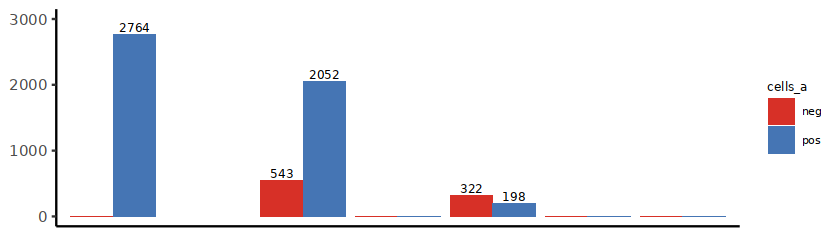

In [32]:
options(repr.plot.width=7, repr.plot.height=2)
markers_d5_other = combined_deg_seurat %>%
    filter(fgf1_day == 'Day5'  &
           grouping == 'fgf1_grouping') %>%
    filter(class == 'other')
ggp_d5_other = make_marker_bars(markers_d5_other, cluster_categories, 3000) +
                theme(axis.text.x = element_blank(),
                        axis.ticks.x = element_blank())
ggp_d5_other

# A tibble: 14 × 4
   cluster           cells_a          n n_label
   <chr>             <chr>        <int> <chr>  
 1 Oligodendrocytes  neg_restored   320 "320"  
 2 Astrocytes        neg_restored   157 "157"  
 3 Tanycytes         neg_restored     0 ""     
 4 Tanycytes         pos_restored     0 ""     
 5 OPC               neg_restored     0 ""     
 6 OPC               pos_restored     0 ""     
 7 Astrocytes        pos_restored     0 ""     
 8 Ependymal_cells   neg_restored     0 ""     
 9 Ependymal_cells   pos_restored     0 ""     
10 Oligodendrocytes  pos_restored     0 ""     
11 Microglia         neg_restored     0 ""     
12 Microglia         pos_restored     0 ""     
13 Endothelial_cells neg_restored     0 ""     
14 Endothelial_cells pos_restored     0 ""     


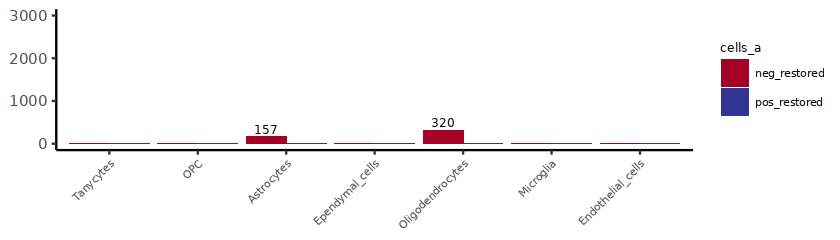

In [33]:
options(repr.plot.width=7, repr.plot.height=2)
markers_d5_other = combined_deg_seurat %>%
    filter(fgf1_day == 'Day5'  &
           grouping == 'restored_grouping') %>%
    filter(class == 'other')  %>%
bind_rows(tibble(cluster = .$cluster, cells_a = 'pos_restored'))
ggp_d5_other_restored = make_marker_bars(markers_d5_other, cluster_categories, 3000)
ggp_d5_other_restored

Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


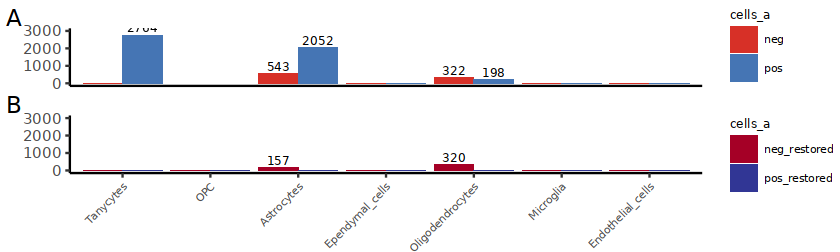

In [34]:
options(repr.plot.width=7, repr.plot.height=2.1)
layout <- '
A
B
'
ggp_all_other = wrap_plots(A = ggp_d5_other,
               B = ggp_d5_other_restored,
        design = layout) +
    plot_layout(guides = 'collect') & 
      theme(plot.margin = margin(2, 0, 0, 2)) 

ggp_all_other = ggp_all_other + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp_all_other %>% ggsave('_targets_MAST_v2/deg_count_plot_other_AB_MAST_v2.pdf', plot = ., width = 7, height=4)
ggp_all_other

# A tibble: 14 × 4
   cluster           cells_a     n n_label
   <chr>             <chr>   <int> <chr>  
 1 Tanycytes         neg         0 ""     
 2 Tanycytes         pos         0 ""     
 3 OPC               neg         0 ""     
 4 OPC               pos         0 ""     
 5 Astrocytes        neg         0 ""     
 6 Astrocytes        pos         0 ""     
 7 Ependymal_cells   neg         0 ""     
 8 Ependymal_cells   pos         0 ""     
 9 Oligodendrocytes  neg         0 ""     
10 Oligodendrocytes  pos         0 ""     
11 Microglia         neg         0 ""     
12 Microglia         pos         0 ""     
13 Endothelial_cells neg         0 ""     
14 Endothelial_cells pos         0 ""     


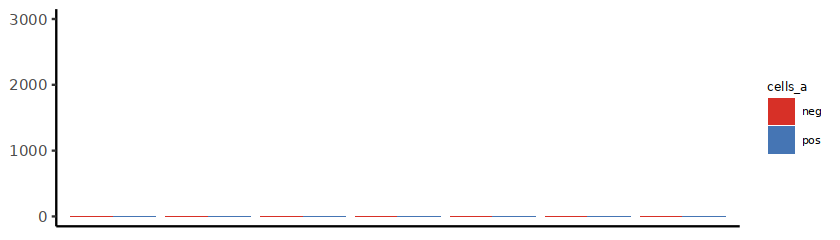

In [35]:
options(repr.plot.width=7, repr.plot.height=2)
markers_d14_other = combined_deg_seurat %>%
    filter(fgf1_day == 'Day14'  &
           grouping == 'fgf1_grouping') %>%
    filter(class == 'other') %>%
bind_rows(tibble(cluster = .$cluster, cells_a = 'neg'))
ggp_d14_other = make_marker_bars(markers_d14_other, cluster_categories, 3000)  +
                theme(axis.text.x = element_blank(),
                        axis.ticks.x = element_blank())
ggp_d14_other

# A tibble: 0 × 4
# ℹ 4 variables: cluster <chr>, cells_a <chr>, n <int>, n_label <chr>


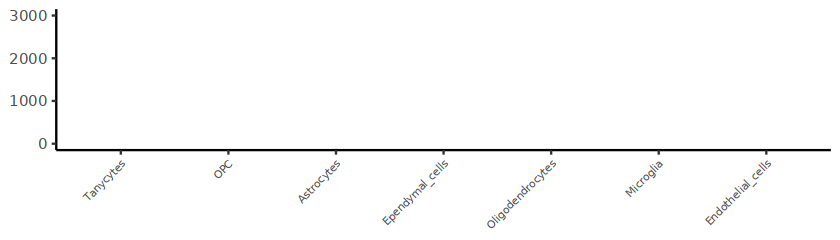

In [36]:
options(repr.plot.width=7, repr.plot.height=2)
markers_d14_other = combined_deg_seurat %>%
    filter(fgf1_day == 'Day14'  &
           grouping == 'restored_grouping') %>%
    filter(class == 'other')

ggp_d14_other_restored = make_marker_bars(markers_d14_other, cluster_categories, 3000)
ggp_d14_other_restored

Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


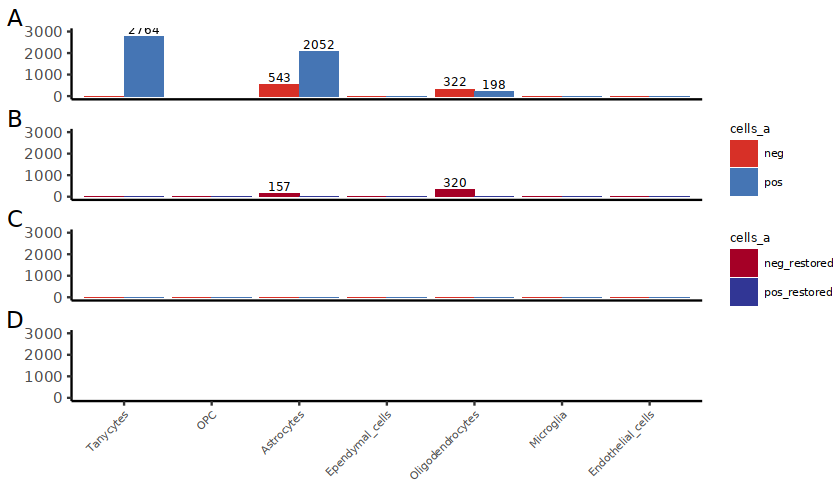

In [37]:
options(repr.plot.width=7, repr.plot.height=4)
layout <- '
A
B
C
D
'

ggp_d5_other_restored = ggp_d5_other_restored   +
                theme(axis.text.x = element_blank(),
                        axis.ticks.x = element_blank())

ggp_all_other = wrap_plots(A = ggp_d5_other,
               B = ggp_d5_other_restored,
               C = ggp_d14_other,
               D = ggp_d14_other_restored,
        design = layout) +
    plot_layout(guides = 'collect') & 
      theme(plot.margin = margin(2, 0, 0, 2)) 

ggp_all_other = ggp_all_other + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp_all_other %>% ggsave('_targets_MAST_v2/deg_count_plot_other_MAST_v2.pdf', plot = ., width = 7, height=4)
ggp_all_other

In [38]:
cluster_categories = labels_classes_tib %>% filter(class == 'neuron') %>% pull(cluster)
cluster_categories

[1] "Sst__Pthlh"          "Nfix__Nfib"          "Met__Prlh"          
 [4] "Agrp"                "Sim1"                "Fez1"               
 [7] "Pou6f2__Prkcq__Whrn" "Dlk1"                "Slc17a6__Trhr"      
[10] "Esr1"                "Tmem215__Dach2"      "Sst__Nts"           
[13] "Sst__Unc13c"         "Irx5__Lmx1a"         "Htr3b"              
[16] "Hdc"                 "Lepr89"              "Nfib_1"             
[19] "Ppp1r17__Tafa4"      "Lepr67"              "Arx__Nr5a2"         
[22] "Kiss1__Tac2"         "Met__Pappa2"         "Trh__Lef1"          
[25] "Gpr50__Tac2"         "Tmem215__Greb1"      "Ghrh"               
[28] "Trh__Cxcl12"         "Lepr15"              "Pomc__Ttr"          
[31] "Tbx19__Pirt"         "Pomc__Glipr1"        "Pomc__Anxa2"        
[34] "Npsr1__Epha3"        "Nfix__Nfib__Lhx6"    "Reln__Lef1"         
[37] "unassigned(2)"       "Th__Nfib"            "Ppp1r17"            
[40] "Th__Slc6a3"          "Nfib_3"              "Ppp1r17__Ltbp1"     
[43] "Lpar1_oligo"         "Nfib_2"              "Nfix__Nfib__Hgf"

In [39]:
cluster_categories = cluster_categories %>% str_replace('/', '__')

# A tibble: 90 × 4
   cluster      cells_a     n n_label
   <chr>        <chr>   <int> <chr>  
 1 Agrp         pos      2819 2819   
 2 Htr3b        neg      2026 2026   
 3 Htr3b        pos      2017 2017   
 4 Sst__Unc13c  pos      1836 1836   
 5 Trh__Lef1    pos       676 676    
 6 Trh__Lef1    neg       554 554    
 7 Agrp         neg       528 528    
 8 Ghrh         neg       309 309    
 9 Kiss1__Tac2  neg       171 171    
10 Pomc__Glipr1 neg       106 106    
# ℹ 80 more rows


Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_text()`).”


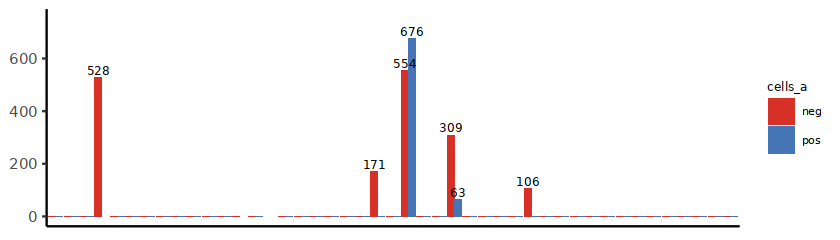

In [40]:
options(repr.plot.width=7, repr.plot.height=2)
markers_d5_neuron = combined_deg_seurat %>%
    filter(fgf1_day == 'Day5'  &
           grouping == 'fgf1_grouping') %>%
    filter(class == 'neuron')
ggp_d5_neuron = make_marker_bars(markers_d5_neuron, cluster_categories, 750) +
                theme(axis.text.x = element_blank(),
                        axis.ticks.x = element_blank())
ggp_d5_neuron

# A tibble: 90 × 4
   cluster      cells_a          n n_label
   <chr>        <chr>        <int> <chr>  
 1 Agrp         pos_restored  3019 "3019" 
 2 Sst__Unc13c  pos_restored  1836 "1836" 
 3 Htr3b        pos_restored  1312 "1312" 
 4 Agrp         neg_restored   528 "528"  
 5 Ghrh         neg_restored   309 "309"  
 6 Kiss1__Tac2  neg_restored   171 "171"  
 7 Pomc__Glipr1 neg_restored   106 "106"  
 8 Ghrh         pos_restored    63 "63"   
 9 Sst__Pthlh   neg_restored     0 ""     
10 Sst__Pthlh   pos_restored     0 ""     
# ℹ 80 more rows


Warning message:
“Removed 3 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_text()`).”


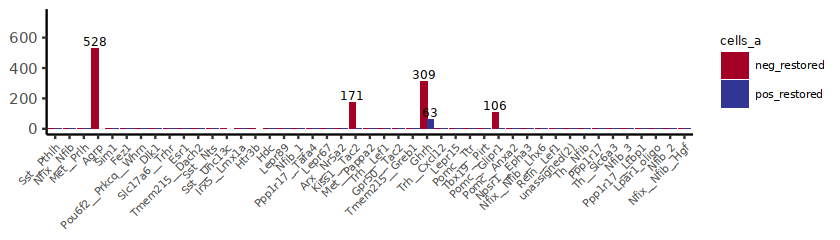

In [41]:
options(repr.plot.width=7, repr.plot.height=2)
markers_d5_neuron = combined_deg_seurat %>%
    filter(fgf1_day == 'Day5'  &
           grouping == 'restored_grouping') %>%
    filter(class == 'neuron')
ggp_d5_neuron_restored = make_marker_bars(markers_d5_neuron, cluster_categories, 750) 
ggp_d5_neuron_restored

# A tibble: 90 × 4
   cluster      cells_a          n n_label
   <chr>        <chr>        <int> <chr>  
 1 Agrp         pos_restored  3019 "3019" 
 2 Sst__Unc13c  pos_restored  1836 "1836" 
 3 Htr3b        pos_restored  1312 "1312" 
 4 Agrp         neg_restored   528 "528"  
 5 Ghrh         neg_restored   309 "309"  
 6 Kiss1__Tac2  neg_restored   171 "171"  
 7 Pomc__Glipr1 neg_restored   106 "106"  
 8 Ghrh         pos_restored    63 "63"   
 9 Sst__Pthlh   neg_restored     0 ""     
10 Sst__Pthlh   pos_restored     0 ""     
# ℹ 80 more rows


Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_text()`).”


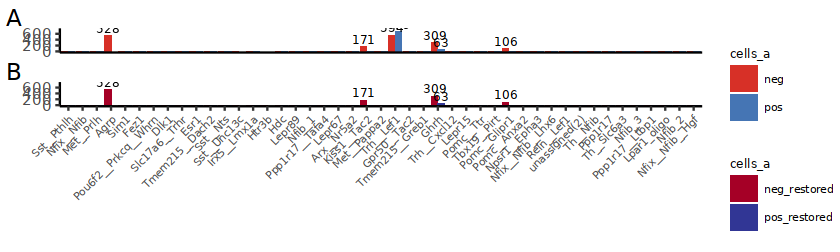

In [42]:
markers_d5_neuron = combined_deg_seurat %>%
    filter(fgf1_day == 'Day5'  &
           grouping == 'restored_grouping') %>%
    filter(class == 'neuron')
ggp_d5_neuron_restored = make_marker_bars(markers_d5_neuron, cluster_categories, 750)
ggp_all_neuron = wrap_plots(A = ggp_d5_neuron,
               B = ggp_d5_neuron_restored,
        design = layout) +
    plot_layout(guides = 'collect') & 
      theme(plot.margin = margin(2, 0, 0, 2))  


options(repr.plot.width=7, repr.plot.height=2.1)
layout <- '
A
B
'

# + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp_all_neuron = ggp_all_neuron + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp_all_neuron %>% ggsave('_targets_MAST_v2/deg_count_plot_neuron_AB_MAST_v2.pdf', plot = ., width = 7, height=4)
ggp_all_neuron

# A tibble: 45 × 4
   cluster             cells_a     n n_label
   <chr>               <chr>   <int> <chr>  
 1 Sst__Pthlh          neg         0 ""     
 2 Nfix__Nfib          neg         0 ""     
 3 Met__Prlh           neg         0 ""     
 4 Agrp                neg         0 ""     
 5 Sim1                neg         0 ""     
 6 Fez1                neg         0 ""     
 7 Pou6f2__Prkcq__Whrn neg         0 ""     
 8 Dlk1                neg         0 ""     
 9 Slc17a6__Trhr       neg         0 ""     
10 Esr1                neg         0 ""     
# ℹ 35 more rows


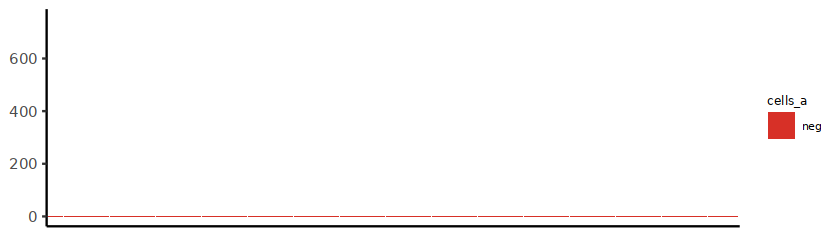

In [43]:
options(repr.plot.width=7, repr.plot.height=2)
markers_d14_neuron = combined_deg_seurat %>%
    filter(fgf1_day == 'Day14'  &
           grouping == 'fgf1_grouping') %>%
    filter(class == 'neuron')
ggp_d14_neuron = make_marker_bars(markers_d14_neuron, cluster_categories, 750)  +
                theme(axis.text.x = element_blank(),
                        axis.ticks.x = element_blank())
ggp_d14_neuron

# A tibble: 0 × 4
# ℹ 4 variables: cluster <chr>, cells_a <fct>, n <int>, n_label <chr>


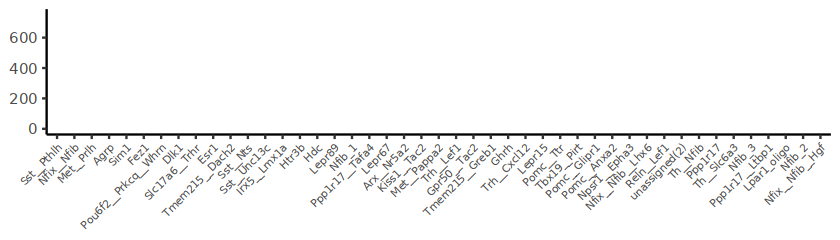

In [44]:
options(repr.plot.width=7, repr.plot.height=2)
markers_d14_neuron = combined_deg_seurat %>%
    filter(fgf1_day == 'Day14'  &
           grouping == 'restored_grouping') %>%
    mutate(cells_a = factor(cells_a, levels=c('neg_restored', 'pos_restored'))) %>%
    filter(class == 'neuron')
ggp_d14_neuron_restored = make_marker_bars(markers_d14_neuron, cluster_categories, 750)
ggp_d14_neuron_restored

Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_text()`).”


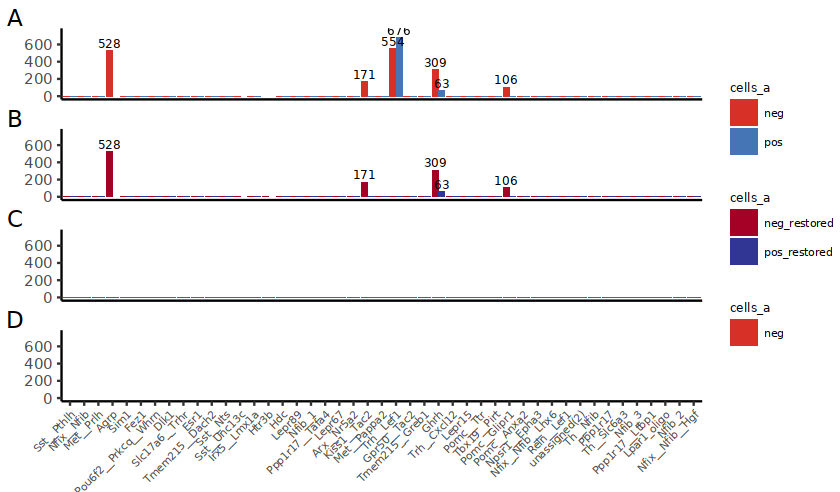

In [45]:
options(repr.plot.width=7, repr.plot.height=4.1)
layout <- '
A
B
C
D
'

ggp_d5_neuron_restored = ggp_d5_neuron_restored  +
                theme(axis.text.x = element_blank(),
                        axis.ticks.x = element_blank())

ggp_all_neuron = wrap_plots(A = ggp_d5_neuron,
               B = ggp_d5_neuron_restored,
               C = ggp_d14_neuron,
               D = ggp_d14_neuron_restored,
        design = layout) +
    plot_layout(guides = 'collect') & 
      theme(plot.margin = margin(2, 0, 0, 2))  

# + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp_all_neuron = ggp_all_neuron + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp_all_neuron %>% ggsave('_targets_MAST_v2/deg_count_plot_neuron_MAST_v2.pdf', plot = ., width = 7, height=4)
ggp_all_neuron

In [46]:
combined_deg_seurat %>% 
filter(cluster == 'Irx5__Lmx1a')

tag,data_day,cluster,class,fgf1_day,fgf1_comparison,bl6_day,bl6_comparison,grouping,cells_a,⋯,pct.2,p_val_adj,ensmusg,gsea_sort_score,count,total_cells,frac,frac_cutoff,n_cells_cutoff,n_cells_valid
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>
Irx5__Lmx1a___Day5.obob5v5__v__Day5.obobBL6d5___bl6_grouping.neg_vs_none,all,Irx5__Lmx1a,neuron,Day5,obob5v5,Day5,obobBL6d5,bl6_grouping,neg,⋯,0.805,1.884031e-169,ENSMUSG00000058925,713.1835,70,2686,0.02606106,0.1,150,FALSE
Irx5__Lmx1a___Day5.obob5v5__v__Day5.obobBL6d5___bl6_grouping.neg_vs_none,all,Irx5__Lmx1a,neuron,Day5,obob5v5,Day5,obobBL6d5,bl6_grouping,neg,⋯,0.869,1.744857e-159,ENSMUSG00000093497,525.1943,70,2686,0.02606106,0.1,150,FALSE
Irx5__Lmx1a___Day5.obob5v5__v__Day5.obobBL6d5___bl6_grouping.neg_vs_none,all,Irx5__Lmx1a,neuron,Day5,obob5v5,Day5,obobBL6d5,bl6_grouping,neg,⋯,0.808,1.301808e-143,ENSMUSG00000061171,500.1280,70,2686,0.02606106,0.1,150,FALSE
Irx5__Lmx1a___Day5.obob5v5__v__Day5.obobBL6d5___bl6_grouping.neg_vs_none,all,Irx5__Lmx1a,neuron,Day5,obob5v5,Day5,obobBL6d5,bl6_grouping,neg,⋯,0.753,1.445177e-127,ENSMUSG00000087388,488.5600,70,2686,0.02606106,0.1,150,FALSE
Irx5__Lmx1a___Day5.obob5v5__v__Day5.obobBL6d5___bl6_grouping.neg_vs_none,all,Irx5__Lmx1a,neuron,Day5,obob5v5,Day5,obobBL6d5,bl6_grouping,neg,⋯,0.662,2.210621e-71,ENSMUSG00000114810,430.0567,70,2686,0.02606106,0.1,150,FALSE
Irx5__Lmx1a___Day5.obob5v5__v__Day5.obobBL6d5___bl6_grouping.neg_vs_none,all,Irx5__Lmx1a,neuron,Day5,obob5v5,Day5,obobBL6d5,bl6_grouping,neg,⋯,0.528,6.009810e-70,ENSMUSG00000055933,372.0814,70,2686,0.02606106,0.1,150,FALSE
Irx5__Lmx1a___Day5.obob5v5__v__Day5.obobBL6d5___bl6_grouping.neg_vs_none,all,Irx5__Lmx1a,neuron,Day5,obob5v5,Day5,obobBL6d5,bl6_grouping,neg,⋯,0.758,2.621778e-81,ENSMUSG00000057981,354.4501,70,2686,0.02606106,0.1,150,FALSE
Irx5__Lmx1a___Day5.obob5v5__v__Day5.obobBL6d5___bl6_grouping.neg_vs_none,all,Irx5__Lmx1a,neuron,Day5,obob5v5,Day5,obobBL6d5,bl6_grouping,neg,⋯,0.563,9.288247e-63,ENSMUSG00000109107,341.4653,70,2686,0.02606106,0.1,150,FALSE
Irx5__Lmx1a___Day5.obob5v5__v__Day5.obobBL6d5___bl6_grouping.neg_vs_none,all,Irx5__Lmx1a,neuron,Day5,obob5v5,Day5,obobBL6d5,bl6_grouping,neg,⋯,0.511,5.027642e-74,ENSMUSG00000000120,329.0092,70,2686,0.02606106,0.1,150,FALSE


In [47]:
combined_deg_seurat %>%
distinct(cluster, class) %>%
filter(is.na(class))

cluster,class
<chr>,<chr>
g1,NA
g2,NA
g3,NA
n0,NA
n1,NA
n2,NA
n3,NA
n5,NA
n8,NA


In [48]:
combined_deg_seurat %>% write_xlsx('_targets_MAST_v2/combined_deg_seurat_d5_d14_MAST_v2.xlsx')